In [130]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import argparse
from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class

# Helper / tools
from soundspaces.mp3d_utils import CATEGORY_INDEX_MAPPING
def get_category_name(idx):
    assert idx >= 0 and idx <=20, f"Invalid category index number: {idx}"

    for k, v in CATEGORY_INDEX_MAPPING.items():
        if v == idx:
            return k

def get_current_scene_id(sim_current_scene):
    return sim_current_scene.strip("data/scene_datasets/mp3d").split("/")[0]

def get_current_ep_category_label(obs_dict):
    return get_category_name(obs_dict["category"].argmax())


In [131]:
config = get_savi_config(
    # config_paths="ss_baselines/av_nav/config/audionav/mp3d/env_test_0.yaml", # RGB + AudiogoalSensor
    config_paths="env_configs/savi/savi_ss1.yaml")
config.defrost()
config.NUM_PROCESSES = 1
config.USE_SYNC_VECENV = True
config.USE_VECENV = False

## Override semantic object sensor sizes: does RGB / Depth sensor's shape increase ?
# config.DISPLAY_RESOLUTION = 512
# config.TASK_CONFIG.TASK.SEMANTIC_OBJECT_SENSOR.HEIGHT = 512
# config.TASK_CONFIG.TASK.SEMANTIC_OBJECT_SENSOR.WIDTH = 512

# For smoother videos, with higher res ?
config.TASK_CONFIG.SIMULATOR.USE_RENDERED_OBSERVATIONS = False
config.TASK_CONFIG.SIMULATOR.CONTINUOUS_VIEW_CHANGE = True

config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.WIDTH = 512
config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.HEIGHT = 512
config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.WIDTH = 512
config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HEIGHT = 512

# Add support for TOP_DOWN_MAP
config.TASK_CONFIG.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.freeze()
# print(config)

print(config)

BASE_TASK_CONFIG_PATH: env_configs/savi/base_semantic_audiogoal.yaml
CHECKPOINT_FOLDER: data/models/output/data
CHECKPOINT_INTERVAL: 50
CMD_TRAILING_OPTS: []
CONTINUOUS: False
DEBUG: False
DISPLAY_RESOLUTION: 128
ENV_NAME: AudioNavRLEnv
EVAL:
  SPLIT: val
  USE_CKPT_CONFIG: True
EVAL_CKPT_PATH_DIR: data/models/output/data
EXTRA_RGB: False
LOG_FILE: data/models/output/train.log
LOG_INTERVAL: 10
MODEL_DIR: data/models/output
NUM_PROCESSES: 1
NUM_UPDATES: 20000
RL:
  DDPPO:
    backbone: custom_resnet18
    distrib_backend: GLOO
    num_recurrent_layers: 1
    pretrained: True
    pretrained_weights: data/models/savi/data/ckpt.XXX.pth
    reset_critic: False
    rnn_type: GRU
    sync_frac: 0.6
  DISTANCE_REWARD_SCALE: 1.0
  PPO:
    BELIEF_PREDICTOR:
      audio_only: False
      current_pred_only: False
      lr: 0.001
      normalize_category_distribution: False
      online_training: True
      train_encoder: False
      use_label_belief: True
      use_location_belief: True
      wei

In [132]:
envs = construct_envs(config, get_env_class(config.ENV_NAME))

2023-05-15 18:29:57,475 Initializing dataset SemanticAudioNav
2023-05-15 18:29:57,488 Initializing dataset SemanticAudioNav
2023-05-15 18:30:46,805 initializing sim SoundSpacesSim
2023-05-15 18:31:01,577 Initializing task SemanticAudioNav


[18:30:46:844065]:[Metadata] AttributesManagerBase.h(380)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : default.scene_dataset_config.json from original name : default| This file does not exist.
[18:30:46:844174]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
[18:30:46:844217]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DWireframe:capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
[18:30:46:844250]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneSolid:coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true) created and registered.
[18:30:46:844283]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneWireframe:coneWireframe_s

In [133]:
obs = envs.reset()
category_idx = obs[0]['category'].argmax()
print(f"Object category: {category_idx} | {get_category_name(category_idx)}")

obs[0]["rgb"].shape

[18:31:03:009843]:[Sensor] AudioSensor.cpp(81)::setAudioSourceTransform : [Audio]  Setting the audio source position :  Vector(-0.808668, 1.03494, -14.8535) ]
[18:31:03:010083]:[Sensor] AudioSensor.cpp(169)::setAudioMaterialsJSON : Set audio materials database to json file :  data/mp3d_material_config.json
[18:31:03:221219]:[Sensor] AudioSensor.cpp(90)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(7.85668, 1.32175, 6.86364) ], rotQuat[ Vector(1, 0, 2.45858e-05, 0) ]
[18:31:03:221288]:[Sensor] AudioSensor.cpp(278)::createAudioSimulator : [Audio]  Create audio simulator iteration:  0
[18:31:03:221588]:[Sensor] AudioSensor.cpp(114)::runSimulation : [Audio]  Running the audio simulator
[18:31:03:221600]:[Sensor] AudioSensor.cpp(119)::runSimulation : [Audio]  New initialization, will upload geometry and add the source at position :  Vector(-0.808668, 1.03494, -14.8535)
[18:31:03:221615]:[Sensor] AudioSensor.cpp(126)::runSimulation : [Audio]  Loading s

(512, 512, 3)

### Checking the observation structure for SAVi

In [134]:
obs[0].keys() # Note: Intermediate will not be present in the first frame.

dict_keys(['depth', 'rgb', 'audiogoal', 'spectrogram', 'category', 'pointgoal_with_gps_compass', 'pose'])

In [135]:
# obs[0]["category"]
obs[0]["pointgoal_with_gps_compass"]

array([22., -9.], dtype=float32)

In [7]:
obs[0]["pose"]

array([-0.,  0.,  0.,  0.], dtype=float32)

### Get oracle actions for SAVi environment ?

In [8]:
envs.workers[0]._env._env._sim._oracle_actions

[1,
 3,
 1,
 2,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 0]

In [9]:
len(envs.workers[0]._env._env._sim._oracle_actions)

55

### Use oracles actions to collect trajectories

In [146]:
obs = envs.reset() # Initial obs, but can we get the corresponding "info" information too ?

oracles_actions = envs.workers[0]._env._env._sim._oracle_actions; len(oracles_actions), oracles_actions
print(f"Env. reset | # oracle actions: {len(oracles_actions)}")

category_idx = obs[0]['category'].argmax()
print(f"Object category: {category_idx} | {get_category_name(category_idx)}")

print(f"Scene ID: {get_current_scene_id(envs.workers[0]._env._env._task._sim._current_scene)}")

[18:33:21:892084]:[Sensor] AudioSensor.cpp(81)::setAudioSourceTransform : [Audio]  Setting the audio source position :  Vector(4.19133, 1.06333, -13.8535) ]
[18:33:21:910874]:[Sensor] AudioSensor.cpp(90)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(7.85668, 1.32175, 6.86364) ], rotQuat[ Vector(1, 0, 2.45858e-05, 0) ]
[18:33:21:910923]:[Sensor] AudioSensor.cpp(278)::createAudioSimulator : [Audio]  Create audio simulator iteration:  33
[18:33:21:910941]:[Sensor] AudioSensor.cpp(114)::runSimulation : [Audio]  Running the audio simulator
[18:33:21:910948]:[Sensor] AudioSensor.cpp(143)::runSimulation : [Audio]  Adding source at position :  Vector(4.19133, 1.06333, -13.8535)
[18:33:21:910963]:[Sensor] AudioSensor.cpp(151)::runSimulation : Running simulation, folder :  /home/AudioSimulation33
[18:33:21:926442]:[Sensor] AudioSensor.cpp(259)::getObservationSpace : [Audio]  getObservationSpace -> [ChannelCount] :  2 , [SampleCount] :  14494
[18:33:21:9311

In [147]:
obs_list, reward_list, done_list, info_list = [], [], [], []

for act in oracles_actions:
    outputs = envs.step([act])
    obs, reward, done, info = [list(x) for x in zip(*outputs)]
    obs[0]["depth"] = obs[0]["depth"] # From [H, W, 1, 1] -> [H, W, 1]

    obs_list.append(obs[0])
    reward_list.append(reward[0])
    done_list.append(done[0])
    info_list.append(info[0])

len(obs_list), len(reward_list), len(done_list), len(info_list) # should be the same

[18:33:26:064228]:[Sensor] AudioSensor.cpp(90)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(7.19133, 1.02569, 7.1465) ], rotQuat[ Vector(-0.0784591, 0, 0.996917, 0) ]
[18:33:26:064293]:[Sensor] AudioSensor.cpp(278)::createAudioSimulator : [Audio]  Create audio simulator iteration:  36
[18:33:26:064312]:[Sensor] AudioSensor.cpp(114)::runSimulation : [Audio]  Running the audio simulator
[18:33:26:064323]:[Sensor] AudioSensor.cpp(151)::runSimulation : Running simulation, folder :  /home/AudioSimulation36
[18:33:26:098242]:[Sensor] AudioSensor.cpp(259)::getObservationSpace : [Audio]  getObservationSpace -> [ChannelCount] :  2 , [SampleCount] :  14502
[18:33:26:105203]:[Sensor] AudioSensor.cpp(90)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(7.19133, 1.02569, 7.1465) ], rotQuat[ Vector(-0.156434, 0, 0.987688, 0) ]
[18:33:26:105257]:[Sensor] AudioSensor.cpp(278)::createAudioSimulator : [Audio]  Create audio sim

(47, 47, 47, 47)

DEPTH | RGB shapes:  (512, 512, 1) (512, 512, 3)
Object category: 11 | stool


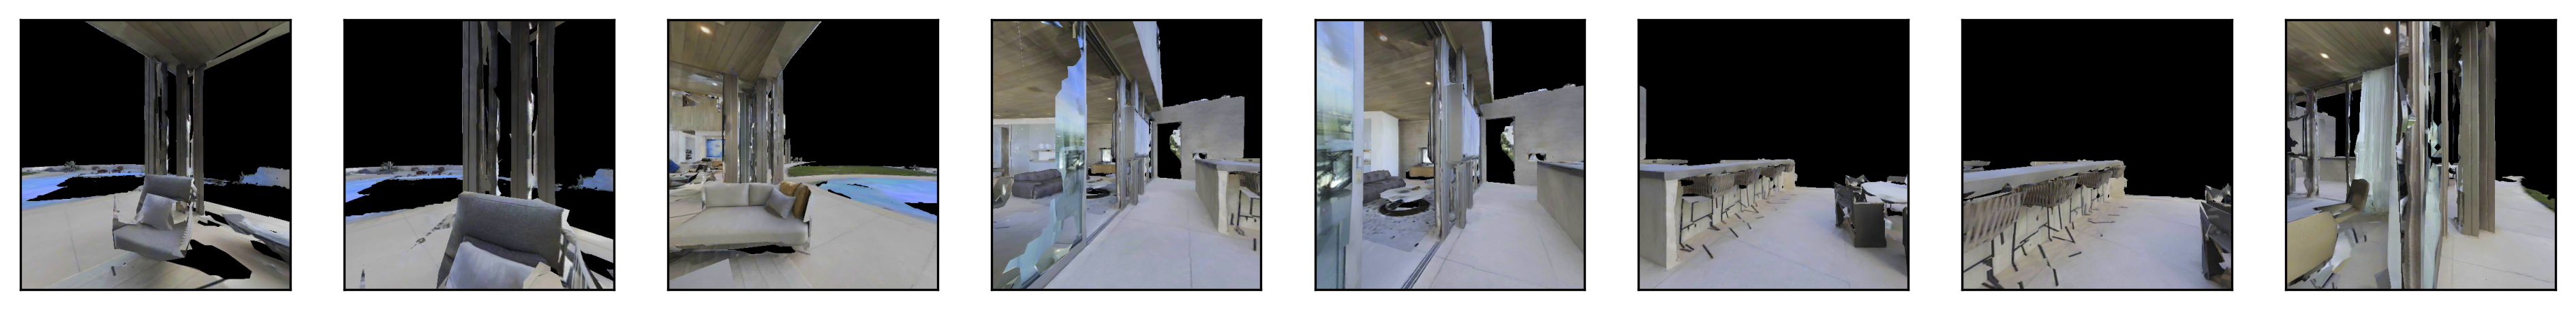

In [148]:
print("DEPTH | RGB shapes: ", obs_list[0]["depth"].shape, obs_list[0]["rgb"].shape)
category_idx = obs_list[0]['category'].argmax()
print(f"Object category: {category_idx} | {get_category_name(category_idx)}")

truncated_obs_list = [*obs_list[:3], *obs_list[-5:]]
fig, axes = plt.subplots(1, len(truncated_obs_list), figsize=(16, 64), dpi=300)
fig.set_facecolor("white")

# plt.tick_params(axis="both", which="both", bottom=False, top=False,  labelbottom=False)
for t, obs_dict in enumerate(truncated_obs_list):
    axes[t].imshow(truncated_obs_list[t]["rgb"])
    axes[t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)

fig.show()

In [149]:
## checking out 'info' after having added the VIDEO_OPTIONS and TOP_DOWN_MAP visualikzation option
info_list[0].keys()
for k, v in info_list[-1].items():
    print(f"{k} : {v}")

distance_to_goal : 0.0
normalized_distance_to_goal : 0.0
success : 1.0
spl : 0.9995896672798474
softspl : 0.9995896672798474
na : 47
sna : 1.0
sws : 1.0
top_down_map : {'map': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'fog_of_war_mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'agent_map_coord': (59, 565), 'agent_angle': 3.141592653589793}


In [150]:
## Check the presence of "intermediate" in observation dict for smoother video generation ?
obs_list[0].keys() # It does exist if using config.TASK_CONFIG.SIMULATOR.CONTINUOUS_VIEW_CHANGE = True
len(obs_list[0]["intermediate"])

9

In [151]:
## Inspecting top-down map field
info_list[0]["top_down_map"].keys() # dict_keys(['map', 'fog_of_war_mask', 'agent_map_coord', 'agent_angle'])

def rescale_linear(array, new_min, new_max):
    """Rescale an array linearly."""
    minimum, maximum = np.min(array), np.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

# info_list[0]["top_down_map"]["map"] = rescale_linear(info_list[0]["top_down_map"]["map"], 0, 255)
# info_list[0]["top_down_map"]["fog_of_war_mask"] = rescale_linear(info_list[0]["top_down_map"]["fog_of_war_mask"], 0, 255)

In [152]:
info_list[0]["top_down_map"]["map"].min(), info_list[0]["top_down_map"]["map"].max()
info_list[0]["top_down_map"]["fog_of_war_mask"].min(), info_list[0]["top_down_map"]["fog_of_war_mask"].max()

# fig, ax = plt.subplots(1, 1, figsize=(16, 16), dpi=300)
# ax.imshow(info_list[0]["top_down_map"]["map"])

# fig, ax = plt.subplots(1, 1, figsize=(16, 16), dpi=300)
# ax.imshow(info_list[-2]["top_down_map"]["map"])

(0, 1)

In [153]:
# fig, ax = plt.subplots(1, 1, figsize=(24, 24), dpi=200)
# ax.imshow(info_list[-2]["top_down_map"]["fog_of_war_mask"])

In [154]:
## Plotting waveforms
obs_list[0]["audiogoal"].shape

(2, 16000)

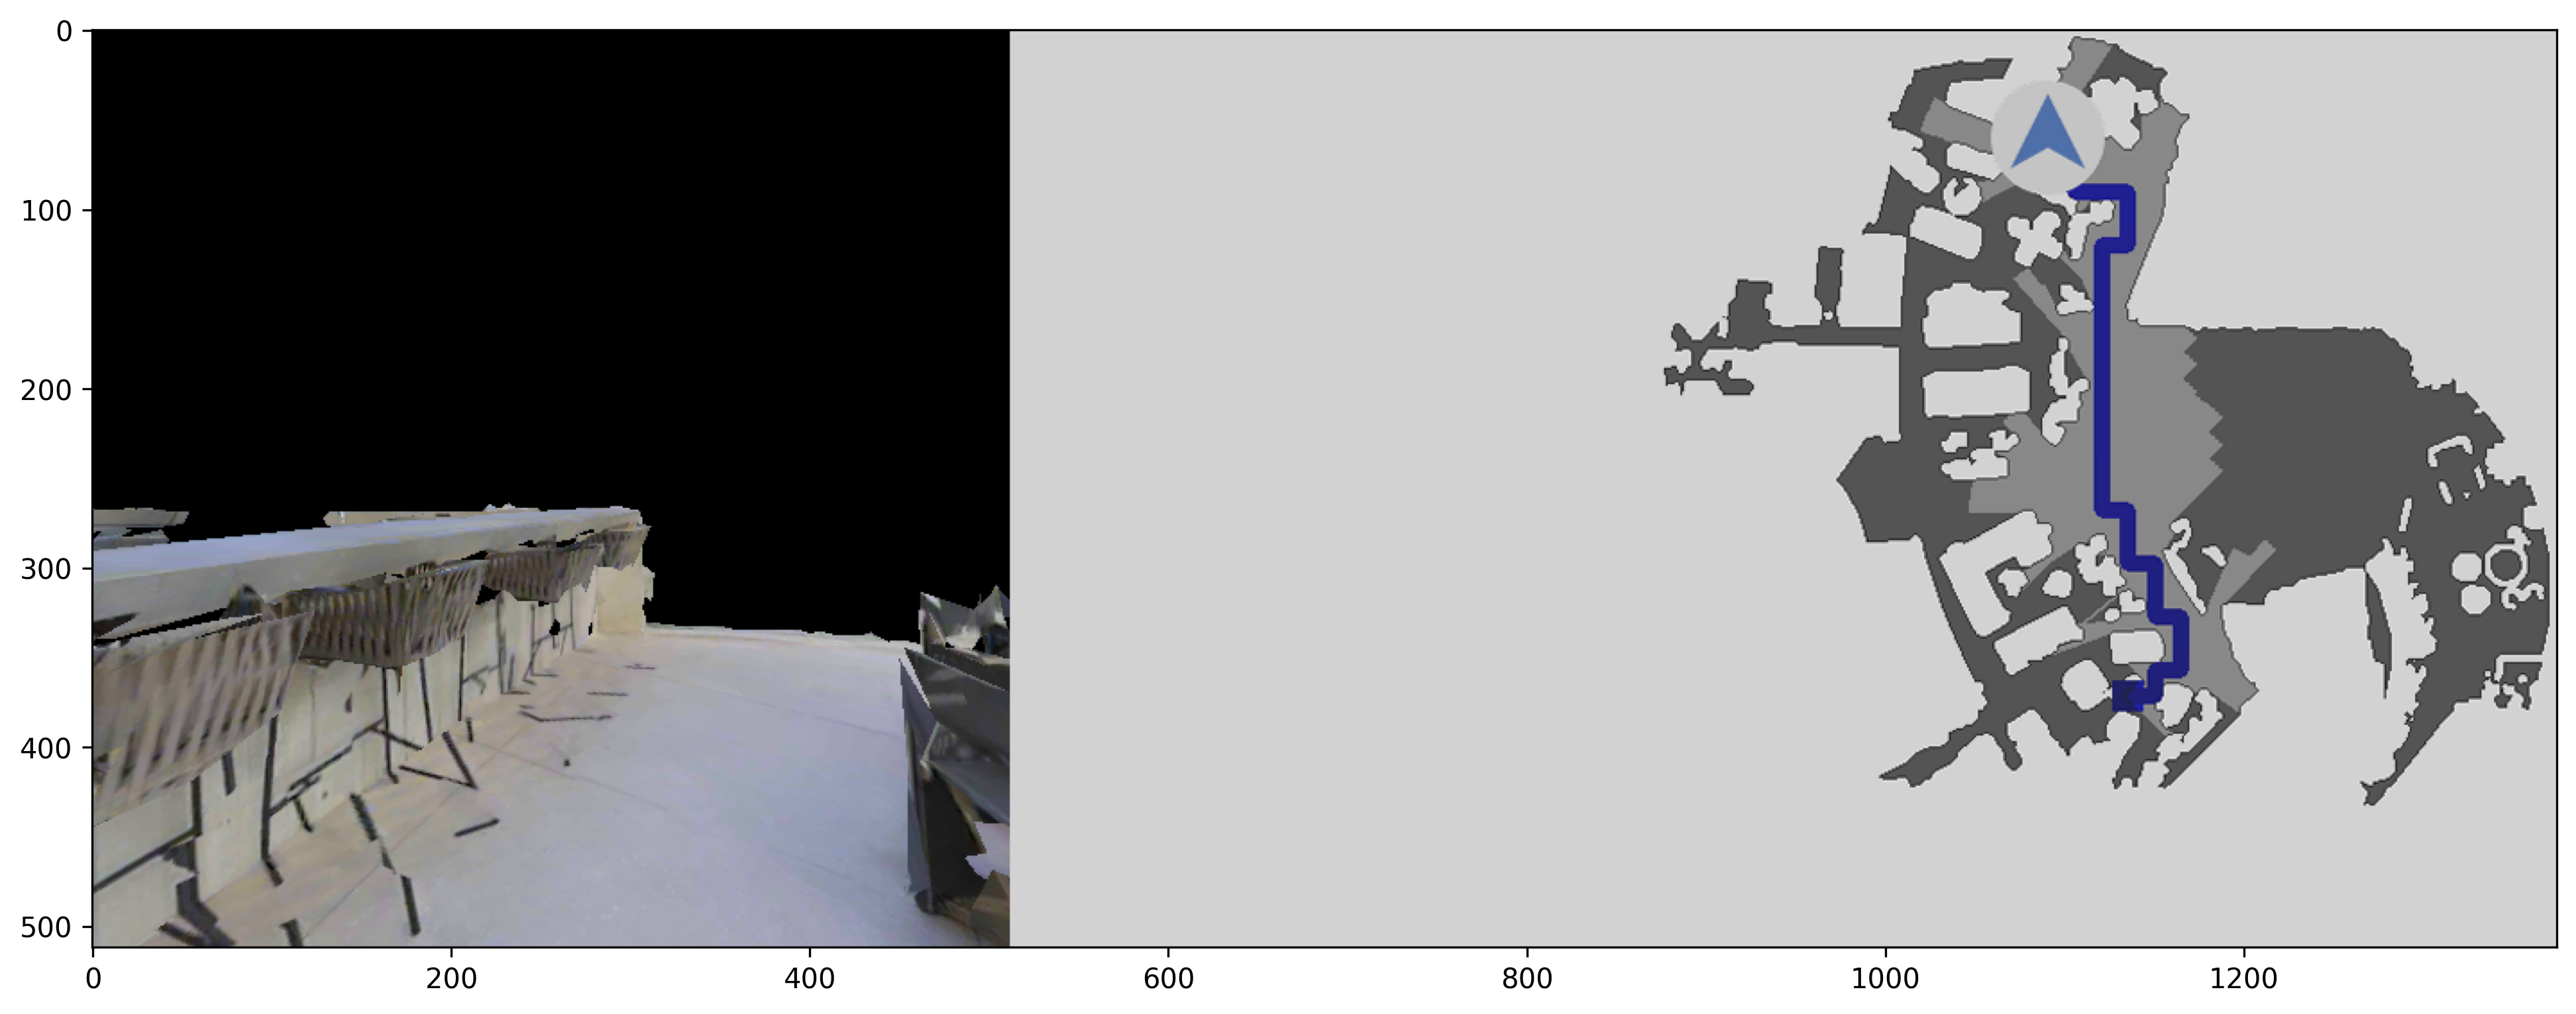

In [155]:
import cv2
from typing import Dict
import torch as th
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import draw_collision
from ss_baselines.common.utils import convert_semantics_to_rgb, observations_to_image

img = observations_to_image(obs_list[-2], info_list[-2], with_depth=False)
img.shape, img.min(), img.max()
fig, ax = plt.subplots(1, 1, figsize=(16, 16), dpi=300)
ax.imshow(img.clip(0, 255))

In [156]:
obs_list[-2]["rgb"].min(), obs_list[-2]["rgb"].max()
obs_list[-2]["depth"].min(), obs_list[-2]["depth"].max(), obs_list[-2]["depth"].shape

(0.0, 0.40845734, (512, 512, 1))

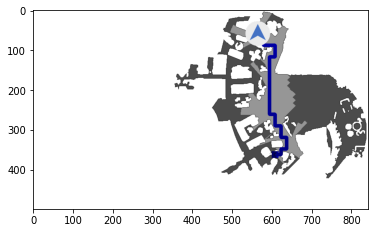

In [157]:
## Testing the plot_top_down_map function
from ss_baselines.common.utils import plot_top_down_map
img = plot_top_down_map(info=info_list[-2]); img.shape
plt.imshow(img)

In [158]:
### Generating videos with audios
video__img_list = []
video__aud_list = []

## Recover scene id and category
get_current_scene_id(envs.workers[0]._env._env._task._sim._current_scene), get_current_ep_category_label(obs_list[-2])

for t in range(len(obs_list[:-1])):
    video__img_list.append(
        observations_to_image(obs_list[t], info_list[t], with_depth=False)
    )
    video__aud_list.append(
        obs_list[t]["audiogoal"]
    )

from ss_baselines.common.utils import images_to_video_with_audio

scene_id, target_name = get_current_scene_id(envs.workers[0]._env._env._task._sim._current_scene), get_current_ep_category_label(obs_list[-2])
images_to_video_with_audio(
    images=video__img_list,
    audios=video__aud_list,
    sr=16000,
    fps=5,
    output_dir="/tmp",
    video_name=f"savi_vid_audio__{scene_id}_{target_name}"
)


Moviepy - Building video /tmp/savi_vid_audio__kEZ7cmS4wCh_stool.mp4.
MoviePy - Writing audio in savi_vid_audio__kEZ7cmS4wCh_stoolTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /tmp/savi_vid_audio__kEZ7cmS4wCh_stool.mp4



Moviepy - Done !
Moviepy - video ready /tmp/savi_vid_audio__kEZ7cmS4wCh_stool.mp4


### Checking structures of the `envs` object

In [29]:
envs.__dict__

{'_is_waiting': False,
 '_is_closed': True,
 '_num_envs': 1,
 '_auto_reset_done': True,
 'workers': [<ss_baselines.common.sync_vector_env.WorkerEnv at 0x7f3b7d986f70>],
 'observation_spaces': [Dict(audiogoal:Box(-3.4028235e+38, 3.4028235e+38, (2, 16000), float32), category:Box(False, True, (21,), bool), depth:Box(0.0, 1.0, (512, 512, 1), float32), pointgoal_with_gps_compass:Box(-3.4028235e+38, 3.4028235e+38, (2,), float32), pose:Box(-3.4028235e+38, 3.4028235e+38, (4,), float32), rgb:Box(0, 255, (512, 512, 3), uint8), spectrogram:Box(-3.4028235e+38, 3.4028235e+38, (65, 26, 2), float32))],
 'action_spaces': [ActionSpace(MOVE_FORWARD:EmptySpace(), STOP:EmptySpace(), TURN_LEFT:EmptySpace(), TURN_RIGHT:EmptySpace())],
 '_paused': []}

In [32]:
envs.workers[0].__dict__

{'_env': <ss_baselines.common.environments.AudioNavRLEnv at 0x7f398b02ce20>,
 '_auto_reset_done': True}

In [31]:
envs.workers[0]._env.__dict__

{'_rl_config': Config({'SUCCESS_REWARD': 10.0, 'SLACK_REWARD': -0.01, 'WITH_TIME_PENALTY': True, 'WITH_DISTANCE_REWARD': True, 'DISTANCE_REWARD_SCALE': 1.0, 'TIME_DIFF': False, 'PPO': Config({'clip_param': 0.2, 'ppo_epoch': 2, 'num_mini_batch': 2, 'value_loss_coef': 0.5, 'entropy_coef': 0.05, 'lr': 0.00025, 'eps': 1e-05, 'max_grad_norm': 0.2, 'num_steps': 150, 'hidden_size': 512, 'use_gae': True, 'use_linear_lr_decay': False, 'use_linear_clip_decay': False, 'gamma': 0.99, 'tau': 0.95, 'reward_window_size': 50, 'use_normalized_advantage': False, 'policy_type': 'smt', 'use_external_memory': True, 'use_mlp_state_encoder': False, 'SCENE_MEMORY_TRANSFORMER': Config({'memory_size': 150, 'hidden_size': 256, 'nhead': 8, 'num_encoder_layers': 1, 'num_decoder_layers': 1, 'dropout': 0.0, 'activation': 'relu', 'use_pretrained': False, 'pretrained_path': '', 'freeze_encoders': True, 'pretraining': False, 'use_action_encoding': True, 'use_belief_encoding': False}), 'use_belief_predictor': True, 'BEL

In [33]:
envs.workers[0]._env._env.__dict__

{'_config': Config({'SEED': 100, 'ENVIRONMENT': Config({'MAX_EPISODE_STEPS': 500, 'MAX_EPISODE_SECONDS': 10000000, 'ITERATOR_OPTIONS': Config({'CYCLE': True, 'SHUFFLE': True, 'GROUP_BY_SCENE': True, 'NUM_EPISODE_SAMPLE': -1, 'MAX_SCENE_REPEAT_EPISODES': -1, 'MAX_SCENE_REPEAT_STEPS': 10000, 'STEP_REPETITION_RANGE': 0.2})}), 'TASK': Config({'REWARD_MEASURE': 'distance_to_goal', 'SUCCESS_MEASURE': 'spl', 'SUCCESS_REWARD': 2.5, 'SLACK_REWARD': -0.01, 'END_ON_SUCCESS': False, 'TYPE': 'SemanticAudioNav', 'SENSORS': ['AUDIOGOAL_SENSOR', 'SPECTROGRAM_SENSOR', 'CATEGORY', 'POINTGOAL_WITH_GPS_COMPASS_SENSOR', 'POSE_SENSOR'], 'MEASUREMENTS': ['DISTANCE_TO_GOAL', 'NORMALIZED_DISTANCE_TO_GOAL', 'SUCCESS', 'SPL', 'SOFT_SPL', 'NUM_ACTION', 'SUCCESS_WEIGHTED_BY_NUM_ACTION', 'SUCCESS_WHEN_SILENT', 'TOP_DOWN_MAP'], 'GOAL_SENSOR_UUID': 'spectrogram', 'POSSIBLE_ACTIONS': ['STOP', 'MOVE_FORWARD', 'TURN_LEFT', 'TURN_RIGHT'], 'MAX_COLLISIONS': -1.0, 'COUNT_OBJ_COLLISIONS': True, 'COUNT_ROBOT_OBJ_COLLS': Fals

In [34]:
envs.workers[0]._env._env._sim._oracle_actions

[3,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 0]

In [ ]:
envs.reset()
envs.workers[0]._env._env._sim._oracle_actions

## Attempt at using the `ShortestPathFollower` class

In [ ]:
envs.workers[0]._env._env._sim.__dict__

In [ ]:
envs.workers[0]._env._env._sim._sim # <soundspaces.simulator.DummySimulator at 0x7f9556ccf910>

In [ ]:
import habitat_sim
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat.sims.habitat_simulator.habitat_simulator import HabitatSim

type(envs.workers[0]._env._env._sim)

envs.workers[0]._env._env._sim.make_greedy_follower(
    agent_id = 0,
    goal_radius = 0.5,
    stop_key=HabitatSimActions.STOP,
    forward_key=HabitatSimActions.MOVE_FORWARD,
    left_key=HabitatSimActions.TURN_LEFT,
    right_key=HabitatSimActions.TURN_RIGHT
)

In [ ]:
# Instantiate a Shortest Path Follower agent
from soundspaces.tasks.shortest_path_follower import ShortestPathFollower

spf_agent = ShortestPathFollower(sim = envs.workers[0]._env._env._sim, goal_radius = 0.5)
spf_agent._build_follower()

### Attempt at extracting Top Down Map and other trajectory analysis information

In [ ]:
action_fwd = {"action": "MOVE_FORWARD", "action_args": None}
observation, reward, done, info = envs.step(**action_fwd)

In [ ]:
info

In [ ]:
info["top_down_map"]["map"].shape, info["top_down_map"]["fog_of_war_mask"].shape

In [ ]:
plt.imshow(info["top_down_map"]["map"])

In [ ]:
plt.imshow(info["top_down_map"]["fog_of_war_mask"])

In [ ]:
# (info["top_down_map"]["map"] * info["top_down_map"]["fog_of_war_mask"]).shape
plt.imshow(info["top_down_map"]["map"] * info["top_down_map"]["fog_of_war_mask"])